In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import regex
from sklearn.metrics import f1_score, hamming_loss, average_precision_score
from torch.utils.data import DataLoader, TensorDataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.normalizers import BertNormalizer
from tokenizers.pre_tokenizers import BertPreTokenizer
from pathlib import Path
import time
import copy
from tqdm.auto import tqdm
from IPython.display import display, update_display
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import json, random
from scipy.stats import wilcoxon, rankdata

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = "third" # "second" "third"
path = "./second_dataset/mbti_1.csv"
seed = 0
torch.manual_seed(seed)
# Data
train_fraction = 0.80
val_fraction = 0.10
vocab_size = 20000
seq_len = 512 
vocab = "vocab"
preset_token = ["__pad__", "__url__", "__sep__", "__tar__", "__unk__"]
token_col = "tokens"
target_cols = ["I_E", "N_S", "T_F", "J_P"]
pad_id = 0
targets = 4

# Model
cfg_embed_dim = 512 # (128, 256, 384, 512) 
cfg_hidden_dim = 384 # (128, 256, 384, 512)
cfg_num_layers = 1 # (1, 2, 3)
cfg_dropout = 0.2 # 0.2-0.5
cfg_bidirectional = True

# Train
cfg_batch_size = 64 # (64, 128, 256)
cfg_lr = 1e-3        # (5e-5, 1e-4, 5e-4, 1e-3) 
cfg_weight_decay = 1e-4 # (5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
cfg_epochs = 20
cfg_max_grad_norm = 0.5 # (0.5–2.0)

if dataset == "third":#
    path = "./third_dataset/MBTI 500.csv"
#     # Model
#     cfg_embed_dim = 512 # (128, 256, 384, 512) 
#     cfg_hidden_dim = 384 # (128, 256, 384, 512)
#     cfg_num_layers = 1 # (1, 2, 3)
#     cfg_dropout = 0.2 # 0.2-0.5
#     cfg_bidirectional = False

#     # Train
#     cfg_batch_size = 64 # (64, 128, 256)
#     cfg_lr = 1e-3        # (5e-5, 1e-4, 5e-4, 1e-3) 
#     cfg_weight_decay = 1e-4 # (5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
#     cfg_max_grad_norm = 0.5 # (0.5–2.0)


In [37]:
# Data curation
def preprocess_df(df):
    posts = df["posts"]
    types = df["type"]
    
    posts = posts.replace(r"http[^\s|]+", " __url__ ", regex=True)
    posts = posts.str.replace("|||", " __sep__ ", regex=False)
    posts = posts.replace(r"(?i)\b[IE][NS][TF][JP]\b", " __tar__ ", regex=True) # i.e. INTP, ENFJ
    
    types = types.replace(r"I|N|T|J", "1", regex=True)
    types = types.replace(r"E|S|F|P", "0", regex=True)
    
    df["posts"] = posts
    df["type"] = types
    
    df[["I_E", "N_S", "T_F", "J_P"]] = (
        df["type"].apply(lambda s: pd.Series([int(c) for c in s]))
    ).astype("int32")
    
    return df.sample(frac=1, random_state=seed).reset_index(drop=True) # shuffle

In [38]:
# cut off data to balance distribution
def equal_dist_sample(df, total_n=10_000, seed=seed) -> pd.DataFrame:
    counts = df["type"].value_counts()
    amt_classes = len(counts)
    amt_per_class = total_n // amt_classes
    need = pd.Series(amt_per_class, index=counts.index)
    amts = need.clip(upper=counts)
    
    parts = [
        df[df["type"] == cls].sample(n=amts[cls], random_state=seed)
        for cls in amts.index
        if amts[cls] > 0
    ]
    out = pd.concat(parts, ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)
    return out


In [39]:
# train/test split
df = pd.read_csv(path)
df = preprocess_df(df)
if dataset == "third":
    df = equal_dist_sample(df)
    counts = df["type"].value_counts()
    print(counts)
    print(sum(counts.values))
    
print(df)

n = len(df)
n_train = int(train_fraction * n)
n_val = int((val_fraction + train_fraction) * n)

train_df = df[ : n_train]
val_df = df[n_train : n_val]
test_df = df[n_val : ]

type
0010    625
1001    625
0110    625
1100    625
1111    625
1110    625
1101    625
1011    625
1010    625
1000    625
0111    625
0101    625
0100    625
0011    482
0000    360
0001    181
Name: count, dtype: int64
9148
                                                  posts  type  I_E  N_S  T_F  \
0     intention part visitor create pleasant feel at...  0010    0    0    1   
1     like enfps enfps welcome  __tar__  bizarrely e...  1001    1    0    0   
2     microwave anyway would say necessarily need th...  0110    0    1    1   
3     kind personality type test online quiz come sp...  1100    1    1    0   
4     lovli når antifascisterne mere eller mindre st...  0011    0    0    1   
...                                                 ...   ...  ...  ...  ...   
9143  opposite song select find interest general pop...  1010    1    0    1   
9144  also idk specific  __tar__  hat need touch hea...  1001    1    0    0   
9145  muiple monopoly kid much age difference kid hu

In [40]:
# Tokenizing function
def tokenize():
    tok = Tokenizer(WordPiece(unk_token="__unk__"))
    tok.normalizer = BertNormalizer(lowercase=True)
    tok.pre_tokenizer = BertPreTokenizer()

    trainer = WordPieceTrainer(vocab_size=vocab_size, special_tokens=preset_token)
    tok.train_from_iterator(train_df["posts"], trainer=trainer)

    tok.save(str(Path(path).parent / "tokenizer.json"))
    print("saved at:", str(Path(path).parent / "tokenizer.json"))
    return tok

In [41]:
# tokenizer
if dataset == "third":
    tok = tokenize()
else:
    try:
        tok = Tokenizer.from_file(str(Path(path).parent / "tokenizer.json"))
    except:
        print("creating new Tokenizer")
        tok = tokenize()

tok.enable_padding(length=seq_len, pad_id=pad_id, pad_token="__pad__")
tok.enable_truncation(max_length=seq_len)

def add_input_ids(df, tok, text_col="posts", out_col=token_col):
    encs = tok.encode_batch(df[text_col].astype(str).tolist())
    df = df.copy()
    df[out_col] = [e.ids for e in encs]
    return df

train_df = add_input_ids(train_df, tok, text_col="posts", out_col=token_col)
val_df   = add_input_ids(val_df,   tok, text_col="posts", out_col=token_col)
test_df  = add_input_ids(test_df,  tok, text_col="posts", out_col=token_col)

y_train = train_df[target_cols].to_numpy(dtype=np.int32)
y_val = val_df[target_cols].to_numpy(dtype=np.int32)
y_test  = test_df[target_cols].to_numpy(dtype=np.int32)


saved at: third_dataset\tokenizer.json


In [42]:
def near_exact_match(y_true, y_pred, min_correct=3):
    correct_per_sample = (y_pred == y_true).sum(axis=1)
    return (correct_per_sample >= min_correct).mean()

In [43]:
# Majority Guessing baseline 
# needs 8 targets
def majority_guessing(y_true):
    priors = y_true.mean(axis=0)
    majority_bits = (priors >= 0.5).astype(np.int32)
    y_pred = np.tile(majority_bits, (len(y_true), 1))
    nem = near_exact_match(y_true, y_pred)
    per_label_acc = (y_true == y_pred).mean(axis=0)
    h_loss = hamming_loss(y_true, y_pred)

    per_label_f1 = [f1_score(y_true[:, j], y_pred[:, j],
                        average="macro", zero_division=0)
                for j in range(y_true.shape[1])]
    f1 = float(np.mean(per_label_f1))

    print("Near Exact match:", nem)
    print("Hamming loss:", h_loss)
    print("MacroF1:", f1), 
    print("per label F1:", per_label_f1)
    print("per label acc:", per_label_acc)

majority_guessing(y_train)

Near Exact match: 0.34244329051653455
Hamming loss: 0.46348045914184205
MacroF1: 0.3491260320477214
per label F1: [0.35319073713982674, 0.35495813133539006, 0.34852666251224074, 0.33982859720342806]
per label acc: [0.54605083 0.55028696 0.53498224 0.51475813]


In [44]:
# balanced ce loss function
# class weights
eps = 1e-4
ce_pos_rate = np.clip(y_train.mean(axis=0), eps, 1-eps)  # pos_rate je Dimension

w0 = 0.5 / (1 - ce_pos_rate)
w1 = 0.5 / ce_pos_rate

class_weights = []
for target in range(targets):
    class_weights.append(torch.tensor([w0[target], w1[target]], dtype=torch.float32, device=device))
    
def balanced_ce_loss(logits, y, class_weights=class_weights):
    loss = 0.0
    for target in range(targets):
        loss = loss + nn.functional.cross_entropy(logits[:, target, :], y[:, target], weight=class_weights[target])
    return loss / targets

In [45]:
# model class
class LSTM_MBTI(nn.Module):
    def __init__(self, embed_dim=cfg_embed_dim, hidden_dim=cfg_hidden_dim, num_layers=cfg_num_layers, dropout=cfg_dropout, bidirectional=cfg_bidirectional):
        super().__init__()
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_id
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(out_dim, 8)
        )

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        out, _ = self.lstm(x)

        mask = (input_ids != pad_id).to(out.dtype)
        mask_size = mask.sum(dim=1, keepdim=True).clamp(min=1.0)
        mean_pooled = (out * mask.unsqueeze(-1)).sum(dim=1) / mask_size

        return self.head(mean_pooled).view(-1, 4, 2)


In [46]:
# dataset
def make_ds(df):
    x = torch.tensor(np.stack(df[token_col].to_list()), dtype=torch.long)
    y = torch.tensor(df[target_cols].to_numpy(np.float32), dtype=torch.float32)
    return TensorDataset(x, y)

In [47]:
# data loaders
train_ds = make_ds(train_df)
val_ds   = make_ds(val_df)
test_ds   = make_ds(test_df)

cfg_train_loader = DataLoader(train_ds, batch_size=cfg_batch_size, shuffle=True,
                        pin_memory=torch.cuda.is_available())
cfg_val_loader = DataLoader(val_ds, batch_size=cfg_batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
cfg_test_loader = DataLoader(test_ds, batch_size=cfg_batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())

In [48]:
# train and eval
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses = []
    y_true_all = []
    y_pred_all = []
    probs_all = []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()

        logits = model(x) #8

        
        loss = balanced_ce_loss(logits, y)
        losses.append(loss.item())

        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        y_true = y.cpu().numpy().astype(np.int32)# 4
        
        y_pred = probs.argmax(-1).astype(np.int32) #8 -> 4

        y_true_all.append(y_true)# 4
        y_pred_all.append(y_pred)# 4
        probs_all.append(probs)# 4 * 2

    
    
    y_true_all = np.vstack(y_true_all)
    y_pred_all = np.vstack(y_pred_all)
    probs_all = np.vstack(probs_all)
    
    ds_size = y_true_all.shape[0]
    idx = np.arange(ds_size)

    # y for 8 logits
    y_true_8 = np.zeros((ds_size, 8), dtype=np.int32)
    y_pred_8 = np.zeros((ds_size, 8), dtype=np.int32)

    probs_8 = np.zeros((ds_size, 8), dtype=np.float32)

    for j in range(4):
        y_true_8[idx, 2*j + y_true_all[:, j]] = 1
        y_pred_8[idx, 2*j + y_pred_all[:, j]] = 1

        probs_8[:, 2*j + 0] = probs_all[:, j, 0]
        probs_8[:, 2*j + 1] = probs_all[:, j, 1]

    
    per_label_f1 = []
    per_label_ap = []
    for j in range(8):
        f1_j = f1_score(y_true_8[:, j], y_pred_8[:, j], average="binary", zero_division=0)
        ap_j = average_precision_score(y_true_8[:, j], probs_8[:, j])
        per_label_f1.append(f1_j)
        per_label_ap.append(ap_j)


    nem = near_exact_match(y_true_all, y_pred_all)
    micro = f1_score(y_true_8, y_pred_8, average="micro", zero_division=0)
    macro = f1_score(y_true_8, y_pred_8, average="macro", zero_division=0)
    macro_ap = np.mean(per_label_ap)
    ham = hamming_loss(y_true_all, y_pred_all)
    
    
    return {
        "loss": float(np.mean(losses)),
        "hamming_loss": float(ham),
        "nem": float(nem),
        "microF1": float(micro),
        "macroF1": float(macro),
        "macroAP": float(macro_ap),
        "per_label_f1": per_label_f1,
    }

def train(model, epochs=cfg_epochs, lr=cfg_lr, weight_decay=cfg_weight_decay, max_grad_norm=cfg_max_grad_norm,
        train_loader=cfg_train_loader, val_loader=cfg_val_loader, output=True, save_all_epochs=False):
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.5,
        patience=3,
        threshold=2e-3,
        threshold_mode="rel"
    )
    
    history = {
        "nem": [],
        "train_loss": [],
        "val_loss": [],
        "val_macroF1": [],
        "val_macroAP": [],
    }

    chosen_f1 = -np.inf
    best_state = None
    state_epoch = 0
    earliest_epoch=3 #also adjusts window size
    states = [None]*earliest_epoch
    f1_window = deque(maxlen=earliest_epoch)
    f1_window_means = [np.nan]*earliest_epoch
    f1_window_stds = [np.nan]*earliest_epoch
    smoothed_best = -np.inf
    
    if output:
        val_display_id = "val_details"
        display("", display_id=val_display_id)
        pbar = tqdm(total=epochs)
    
    for epoch in range(1, epochs + 1):
        start = time.perf_counter()
        model.train()
        running = 0.0
        n_batches = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).long()

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            
            loss = balanced_ce_loss(logits, y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            running += loss.item()
            n_batches += 1

        val = evaluate(model, val_loader)
        
        scheduler.step(val["macroAP"])
        
        train_loss_epoch = running / max(n_batches, 1)
        history["nem"].append(float(val["nem"]))
        history["train_loss"].append(float(train_loss_epoch))
        history["val_loss"].append(float(val["loss"]))
        history["val_macroF1"].append(float(val["macroF1"]))
        history["val_macroAP"].append(float(val["macroAP"]))
            
        delta = 1e-2
        val_f1 = val["macroF1"]
        f1_window.append(val_f1)
        
        if epoch > earliest_epoch:
            smoothed = sum(f1_window) / len(f1_window)
            f1_window_means.append(np.mean(f1_window))
            f1_window_stds.append(np.std(f1_window))
            if save_all_epochs:
                states.append(copy.deepcopy(model.state_dict()))
            elif smoothed > smoothed_best + delta:
                smoothed_best = smoothed
                best_state = copy.deepcopy(model.state_dict())
                state_epoch = epoch
                chosen_f1 = val_f1
        
        if output:
            val_text = (f"VAL  loss={val['loss']:.3f} nem={val['nem']:.3f} hamming_loss={val['hamming_loss']:.3f} "
            f"microF1={val['microF1']:.3f} macroF1={val['macroF1']:.3f} "
            f"per_label_f1={np.round(val['per_label_f1'], 3)}")
            update_display(val_text, display_id=val_display_id)
            
            epoch_time = time.perf_counter() - start
            pbar.set_description(f"Epoch {epoch}/{epochs}")
            pbar.set_postfix_str(f"macroF1={val['macroF1']:.3f} epoch_time={epoch_time:.2f}s")
            pbar.update(1)
        
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"loaded model from epoch {state_epoch}")
        
    if output:
        epochs_r = range(1, len(history["train_loss"]) + 1)
        _, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        means = np.asarray(f1_window_means)
        stds = np.asarray(f1_window_stds)
        ax1.plot(epochs_r, history["val_macroF1"],  "b", label="val_macroF1")
        ax1.plot(epochs_r, history["val_macroAP"], "g", label="val_macroAP")
        ax1.plot(epochs_r, f1_window_means, "y", linestyle="dotted", label="f1 mean")
        ax1.fill_between(epochs_r, means - stds, means + stds, alpha=0.2, label="std")
        ax2.plot(epochs_r, history["nem"],  "r", label="nem")
        ax1.set_ylim(0.6, 0.9)
        ax1.set_ylabel("Score")
        ax1.set_xlim(1, len(epochs_r))
        ax1.xaxis.set_major_locator(mticker.MultipleLocator(1))
        ax1.grid(True, axis='x', which='major', linestyle='-', alpha=0.3)
        ax2.set_ylabel("nem Match")
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")
        plt.show()
    return model, chosen_f1, states


Tuning

In [49]:
def _paired_effect_sizes(old, new):
    old = np.asarray(old, dtype=float)
    new = np.asarray(new, dtype=float)
    diff = new - old

    mask = diff != 0
    masked_diff = diff[mask]
    n = masked_diff.size
    if n == 0:
        return {"n_eff": 0, "rbc": 0.0}

    ranks = rankdata(np.abs(masked_diff), method="average")
    W_plus = ranks[masked_diff > 0].sum()
    W_minus = ranks[masked_diff < 0].sum()
    n_sum = n * (n + 1) / 2.0
    rbc = (W_plus - W_minus) / n_sum

    return {"n_eff": int(n), "rbc": float(rbc)}


def wilcoxon_decision(macro_old, macro_new, alpha=0.05):

    macro_old = np.asarray(macro_old, float)
    macro_new = np.asarray(macro_new, float)

    diff = macro_new - macro_old
    n_eff = np.sum(diff != 0)

    if n_eff == 0:
        return {
            "alpha_used": alpha,
            "old_mean": float(macro_old.mean()),
            "new_mean": float(macro_new.mean()),
            "p": 1.0,
            "stat": 0.0,
            "sig_better": False,
            "note": "all paired diffs are zero; wilcoxon not applicable",
            "effect": _paired_effect_sizes(macro_old, macro_new),
        }
    w_macro = wilcoxon(macro_new, macro_old, alternative="greater", zero_method="wilcox", correction=True)

    macro_sig = (w_macro.pvalue < alpha)

    return {
        "alpha_used": alpha,
        "old_mean": macro_old.mean(),
        "new_mean": macro_new.mean(),
        "p": w_macro.pvalue,
        "stat": w_macro.statistic,
        "sig_better": macro_sig,
        "effect": _paired_effect_sizes(macro_old, macro_new)
    }

def _to_jsonable(x):
    if isinstance(x, (np.floating, np.integer, np.bool_)):
        return x.item()
    if isinstance(x, np.ndarray):
        return x.tolist()
    return x

def write_jsonl(path: Path, record: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    try:
        with path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record, default=_to_jsonable) + "\n")
    except ValueError as e:
        fallback = {"type": "log_error", "error": repr(e), "record_repr": repr(record)[:2000]}
        with path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(fallback) + "\n")
        


def set_seed(seed):
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def run_one(seed, hparams: dict) -> dict:
    set_seed(seed)
    train_loader = DataLoader(train_ds, batch_size=hparams["batch_size"], shuffle=True,
                        pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=hparams["batch_size"], shuffle=False,
                        pin_memory=torch.cuda.is_available())
    
    model = LSTM_MBTI(embed_dim=hparams["embed_dim"], hidden_dim=hparams["hidden_dim"], num_layers=hparams["num_layers"], dropout=hparams["dropout"], bidirectional=hparams["bidirectional"])
    
    model, _, _ = train(model, lr=hparams["lr"], weight_decay=hparams["weight_decay"],
    max_grad_norm=hparams["max_grad_norm"],
    train_loader=train_loader,
    val_loader= val_loader, output=False)
    return evaluate(model, val_loader)

def eval_setting(tag, hparams, seeds, jsonl_path):
    macro_list = []
    for seed in seeds:
        metrics = run_one(seed, hparams)
        rec = {
            "tag": tag,
            "seed": seed,
            "macroF1": metrics["macroF1"],
            "hamming_loss": metrics["hamming_loss"],
            "macroAP": metrics["macroAP"],
            "loss": metrics["loss"],
            "nem": metrics["nem"],
            "hparams": dict(hparams)
        }
        write_jsonl(jsonl_path, rec)
        macro_list.append(rec["macroF1"])
    return np.array(macro_list)
    
def sequential_tuning(
    hparams: dict,
    seeds = np.arange(0, 20),
    out_dir = "tuning_runs",
    alpha = 0.05,
):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    jsonl_path = out_dir / "log.jsonl"
    csv_path = out_dir / "summary.csv"
    
    current = {
        "embed_dim": cfg_embed_dim,
        "hidden_dim": cfg_hidden_dim,
        "num_layers": cfg_num_layers,
        "dropout": cfg_dropout,
        "bidirectional": cfg_bidirectional,

        "batch_size": cfg_batch_size,
        "lr": cfg_lr,
        "weight_decay": cfg_weight_decay,
        "max_grad_norm": cfg_max_grad_norm
    }

    macro_cur = eval_setting("current_baseline", current, seeds, jsonl_path)

    summary = []
    for param in hparams.keys():
        cur_val = current[param]
        for candidate in hparams[param]:
            trial = dict(current)
            trial[param] = candidate

            macro_new = eval_setting(f"trial_{param}={candidate}", trial, seeds, jsonl_path)

            decision = wilcoxon_decision(
                macro_old=macro_cur, macro_new=macro_new,
                alpha=alpha
            )

            write_jsonl(jsonl_path, {
                "type": "comparison",
                "param": param,
                "current_value": cur_val,
                "candidate": candidate,
                "decision": decision,
                "current_hparams": dict(current),
                "trial_hparams": dict(trial)
            })

            if decision["sig_better"]:
                current = dict(trial)
                macro_cur = macro_new
                cur_val = candidate

                write_jsonl(jsonl_path, {
                    "type": "accept",
                    "param": param,
                    "accepted_value": candidate,
                    "new_current_hparams": dict(current)
                })

        summary.append({
            "param": param,
            "final_value": cur_val,
            "macroF1_mean": macro_cur.mean(),
            "macroF1_std": macro_cur.std(),
            "current_hparams": json.dumps(dict(current), default=_to_jsonable)
        })
        pd.DataFrame(summary).to_csv(csv_path, index=False)

    write_jsonl(jsonl_path, {"type": "final", "best_hparams": dict(current)})
    return current

In [50]:
iterate_batch_size = [64, 128, 256]
iterate_lr = [1e-4, 5e-4, 1e-3]
iterate_weight_decay = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
iterate_dropout = [0.2, 0.3, 0.4, 0.5]
iterate_max_grad_norm = [0.5, 1.0, 1.5, 2.0]
iterate_hidden_dim = [128, 256, 384, 512]
iterate_num_layers = [1, 2, 3]
iterate_bidirectional = [True, False]
iterate_embed_dim = [128, 256, 384, 512]

hparams = {
    #"batch_size": iterate_batch_size,
    #"lr": iterate_lr,
    #"weight_decay": iterate_weight_decay,
    #"dropout": iterate_dropout,
    #"max_grad_norm": iterate_max_grad_norm,
    #"hidden_dim": iterate_hidden_dim,
    "num_layers": iterate_num_layers,
    "bidirectional": iterate_bidirectional,
    "embed_dim": iterate_embed_dim}



In [16]:
result = sequential_tuning(hparams)
print(result)

loaded model from epoch 6
loaded model from epoch 5
loaded model from epoch 7
loaded model from epoch 4
loaded model from epoch 10
loaded model from epoch 12
loaded model from epoch 9
loaded model from epoch 4
loaded model from epoch 7
loaded model from epoch 5
loaded model from epoch 7
loaded model from epoch 7
loaded model from epoch 4
loaded model from epoch 5
loaded model from epoch 5
loaded model from epoch 5
loaded model from epoch 6
loaded model from epoch 6
loaded model from epoch 5
loaded model from epoch 6
loaded model from epoch 6
loaded model from epoch 5
loaded model from epoch 7
loaded model from epoch 4
loaded model from epoch 10
loaded model from epoch 12
loaded model from epoch 9
loaded model from epoch 4
loaded model from epoch 7
loaded model from epoch 5
loaded model from epoch 7
loaded model from epoch 7
loaded model from epoch 4
loaded model from epoch 5
loaded model from epoch 5
loaded model from epoch 5
loaded model from epoch 6
loaded model from epoch 6
loaded m

Testing

normal test without tuned params


'VAL  loss=1.156 nem=0.769 hamming_loss=0.206 microF1=0.794 macroF1=0.792 per_label_f1=[0.722 0.783 0.808 0.832 0.834 0.845 0.764 0.753]'

  0%|          | 0/20 [00:00<?, ?it/s]

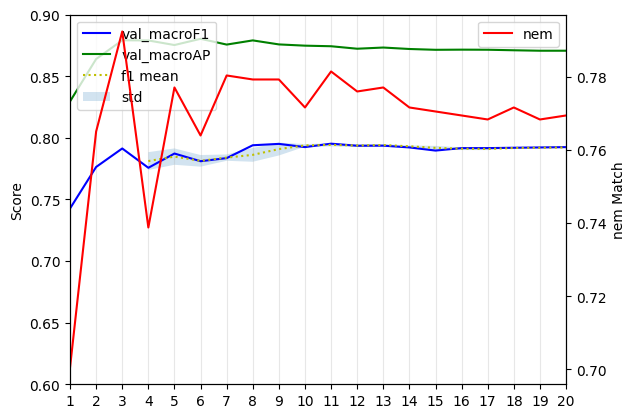

In [51]:
# training

params = {
        "embed_dim": cfg_embed_dim,
        "hidden_dim": cfg_hidden_dim,
        "num_layers": cfg_num_layers,
        "dropout": cfg_dropout,
        "bidirectional": cfg_bidirectional,

        "batch_size": cfg_batch_size,
        "lr": cfg_lr,
        "weight_decay": cfg_weight_decay,
        "max_grad_norm": cfg_max_grad_norm
    }
try:
    params = result
except:
    print("normal test without tuned params")

model = LSTM_MBTI(embed_dim=params["embed_dim"],
    hidden_dim=params["hidden_dim"],
    num_layers=params["num_layers"],
    dropout=params["dropout"],
    bidirectional=params["bidirectional"])

train_loader = DataLoader(train_ds, batch_size=params["batch_size"], shuffle=True,
                        pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=params["batch_size"], shuffle=False,
                        pin_memory=torch.cuda.is_available())
    
model, best_score, states = train(
    model,
    epochs=20,
    lr=params["lr"],
    weight_decay=params["weight_decay"],
    max_grad_norm=params["max_grad_norm"],
    train_loader=train_loader,
    val_loader=val_loader,
    output= True,
    save_all_epochs=True)

In [52]:
chosen_epoch = 11
model.load_state_dict(states[chosen_epoch-1])

<All keys matched successfully>

In [53]:
# model eval
val = evaluate(model, cfg_val_loader)
print(f"VAL loss={val["loss"]:.3f} near exact match={val["nem"]:.3f} hamming_loss={val["hamming_loss"]:.3f} "
            f"microF1={val["microF1"]:.3f}\033[31m macroF1={val["macroF1"]:.3f}\033[0m "
            f"per_label_f1={np.round(val["per_label_f1"], 3)}")

test = evaluate(model, cfg_test_loader)
print(f"TEST loss={test["loss"]:.3f} near exact match={test["nem"]:.3f} hamming_loss={test["hamming_loss"]:.3f} "
            f"microF1={test["microF1"]:.3f}\033[31m macroF1={test["macroF1"]:.3f}\033[0m "
            f"per_label_f1={np.round(test["per_label_f1"], 3)}")

VAL loss=1.030 near exact match=0.781 hamming_loss=0.203 microF1=0.797 macroF1=0.795 per_label_f1=[0.72  0.796 0.807 0.831 0.836 0.843 0.769 0.761]
TEST loss=1.122 near exact match=0.763 hamming_loss=0.219 microF1=0.781 macroF1=0.780 per_label_f1=[0.751 0.798 0.765 0.807 0.797 0.807 0.767 0.747]


In [54]:
# save
save_path = str(Path(path).parent / "model.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "tok": tok,
}, save_path)


In [55]:
# load
ckpt = torch.load(str(Path(path).parent / "model.pt"), map_location="cuda", weights_only=False)

model = LSTM_MBTI()
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

thresholds = ckpt.get("thresholds")
tok = ckpt.get("tok")


In [ ]:
# tokenize input
def tokenize_text(text, tokenizer):
    text = regex.sub(r"http[^\s|]+", " __url__ ", text)
    text = text.replace("|||", " __sep__ ")
    text = regex.sub(r"(?i)\b[IE][NS][TF][JP]\b", " __tar__ ", text)
    text = regex.sub(r"\s+", " ", text)
    rx = regex.compile(r"[^_\p{White_Space}\p{scx=Latin}\p{Emoji}]+")
    text = rx.sub("", text)
    
    return tokenizer.encode(text)

In [ ]:
# predict
zero_out = ["E", "S", "F", "P"]
one_out = ["I", "N", "T", "J"]
def predict(model, tokenized_text):
    model = model.to(device)
    model.eval()
    data = torch.tensor(tokenized_text.ids, dtype=torch.long).unsqueeze(0)
    data = data.to(device)
    with torch.no_grad():
        out = model(data).cpu()
    probs = torch.softmax(out, 2)
    print(np.round(probs, 3))
    bits = probs.argmax(dim=-1)
    mbti = "".join(one_out[i] if bits[0, i].item() == 1 else zero_out[i] for i in range(4))
    
    return mbti

In [ ]:
# input
text = ""
tokens = tokenize_text(text, tok)
out = predict(model, tokens)
print(out)

In [34]:
params = {
        "embed_dim": cfg_embed_dim,
        "hidden_dim": cfg_hidden_dim,
        "num_layers": cfg_num_layers,
        "dropout": cfg_dropout,
        "bidirectional": cfg_bidirectional,

        "batch_size": cfg_batch_size,
        "lr": cfg_lr,
        "weight_decay": cfg_weight_decay,
        "max_grad_norm": cfg_max_grad_norm
    }
evals = []
for seed in range(0, 20):
    print("current seed: ", seed)
    set_seed(seed)
    model = LSTM_MBTI(embed_dim=params["embed_dim"],
    hidden_dim=params["hidden_dim"],
    num_layers=params["num_layers"],
    dropout=params["dropout"],
    bidirectional=params["bidirectional"])

    train_loader = DataLoader(train_ds, batch_size=params["batch_size"], shuffle=True,
                            pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=params["batch_size"], shuffle=False,
                            pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(test_ds, batch_size=params["batch_size"], shuffle=False,
                            pin_memory=torch.cuda.is_available())
        
    model, best_score, states = train(
        model,
        epochs=20,
        lr=params["lr"],
        weight_decay=params["weight_decay"],
        max_grad_norm=params["max_grad_norm"],
        train_loader=train_loader,
        val_loader=val_loader,
        output= False,
        save_all_epochs=False)
    evals.append(evaluate(model, test_loader))
    
keys = ["loss", "hamming_loss", "nem", "microF1", "macroF1", "macroAP"]
mean_metrics = {k: float(np.mean([r[k] for r in evals])) for k in keys}
print(mean_metrics)
    

current seed:  0
loaded model from epoch 6
current seed:  1
loaded model from epoch 4
current seed:  2
loaded model from epoch 4
current seed:  3
loaded model from epoch 6
current seed:  4
loaded model from epoch 7
current seed:  5
loaded model from epoch 6
current seed:  6
loaded model from epoch 6
current seed:  7
loaded model from epoch 6
current seed:  8
loaded model from epoch 6
current seed:  9
loaded model from epoch 6
current seed:  10
loaded model from epoch 6
current seed:  11
loaded model from epoch 7
current seed:  12
loaded model from epoch 5
current seed:  13
loaded model from epoch 7
current seed:  14
loaded model from epoch 7
current seed:  15
loaded model from epoch 6
current seed:  16
loaded model from epoch 6
current seed:  17
loaded model from epoch 6
current seed:  18
loaded model from epoch 4
current seed:  19
loaded model from epoch 6
{'loss': 1.0863698418651309, 'hamming_loss': 0.3097638248847926, 'nem': 0.6398617511520737, 'microF1': 0.6902361751152074, 'macroF